<a href="https://colab.research.google.com/github/RMoulla/Machine-learning/blob/main/TP_GNN_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Réseaux de neurones graphiques à base d'Attention.

Dans ce TP, nous nous proposons d'étudier le dataset Cora. Celui-ci est composé de 2708 papiers scientifiques répartis en sept classes. L'objectif de ce TP est de construire un modèle permettant de prédire la classe à laquelle appartient un noeud (papier scientifique).



In [1]:
import os
import torch
import networkx as nx
import pandas as pd
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.1+cu121
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [79 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-39
      creating build/lib.linux-x86_64-cpython-39/torch_scatter
      copying torch_scatter/segment_coo.py -> build/lib.linux-x86_64-cpython-39/torch_scatter
      copying torch_scatter/utils.py -> build/lib.linux-x86_64-cpython-39/torch_scatter
      copying torch_scatter/__init__.py -> build/lib.linux-x86_64-cpython-39/torch_scatter
      copying torch_scatter/placeholder.py -> build/lib.linux-x86_64-cpython-39/torch_scatter
      copying torch_scatter/scatter.py -> build/lib.linux-x86_64-cpython-39/torch_scatter
      copying torch_scatter/segment_csr.py -> build/lib.linux-x86_64-cpython-39/torch_scatter
      copying torch_scatter/testing.py -> build/lib.linux-x86_64-cpython-39/torch_scatter
  

In [2]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import networkx as nx

## Analyse du dataset Cora

On se propose ici d'explorer le dataset Cora. Il est fortement recommandé de compléter cette analyse exploratoire (visualiser le graphe, etc.).

In [4]:

dataset = Planetoid(root='~/somewhere/Cora', name='Cora')

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False


/home/yasser_wsl/miniconda3/envs/tp/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/home/yasser_wsl/miniconda3/envs/tp/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [10]:
# Création d'un graphe NetworkX à partir des données PyTorch Geometric
G = nx.Graph()

# Ajout des arêtes du graphe
edge_index = data.edge_index.numpy()
edges = [(edge_index[0, i], edge_index[1, i]) for i in range(edge_index.shape[1])]
G.add_edges_from(edges)

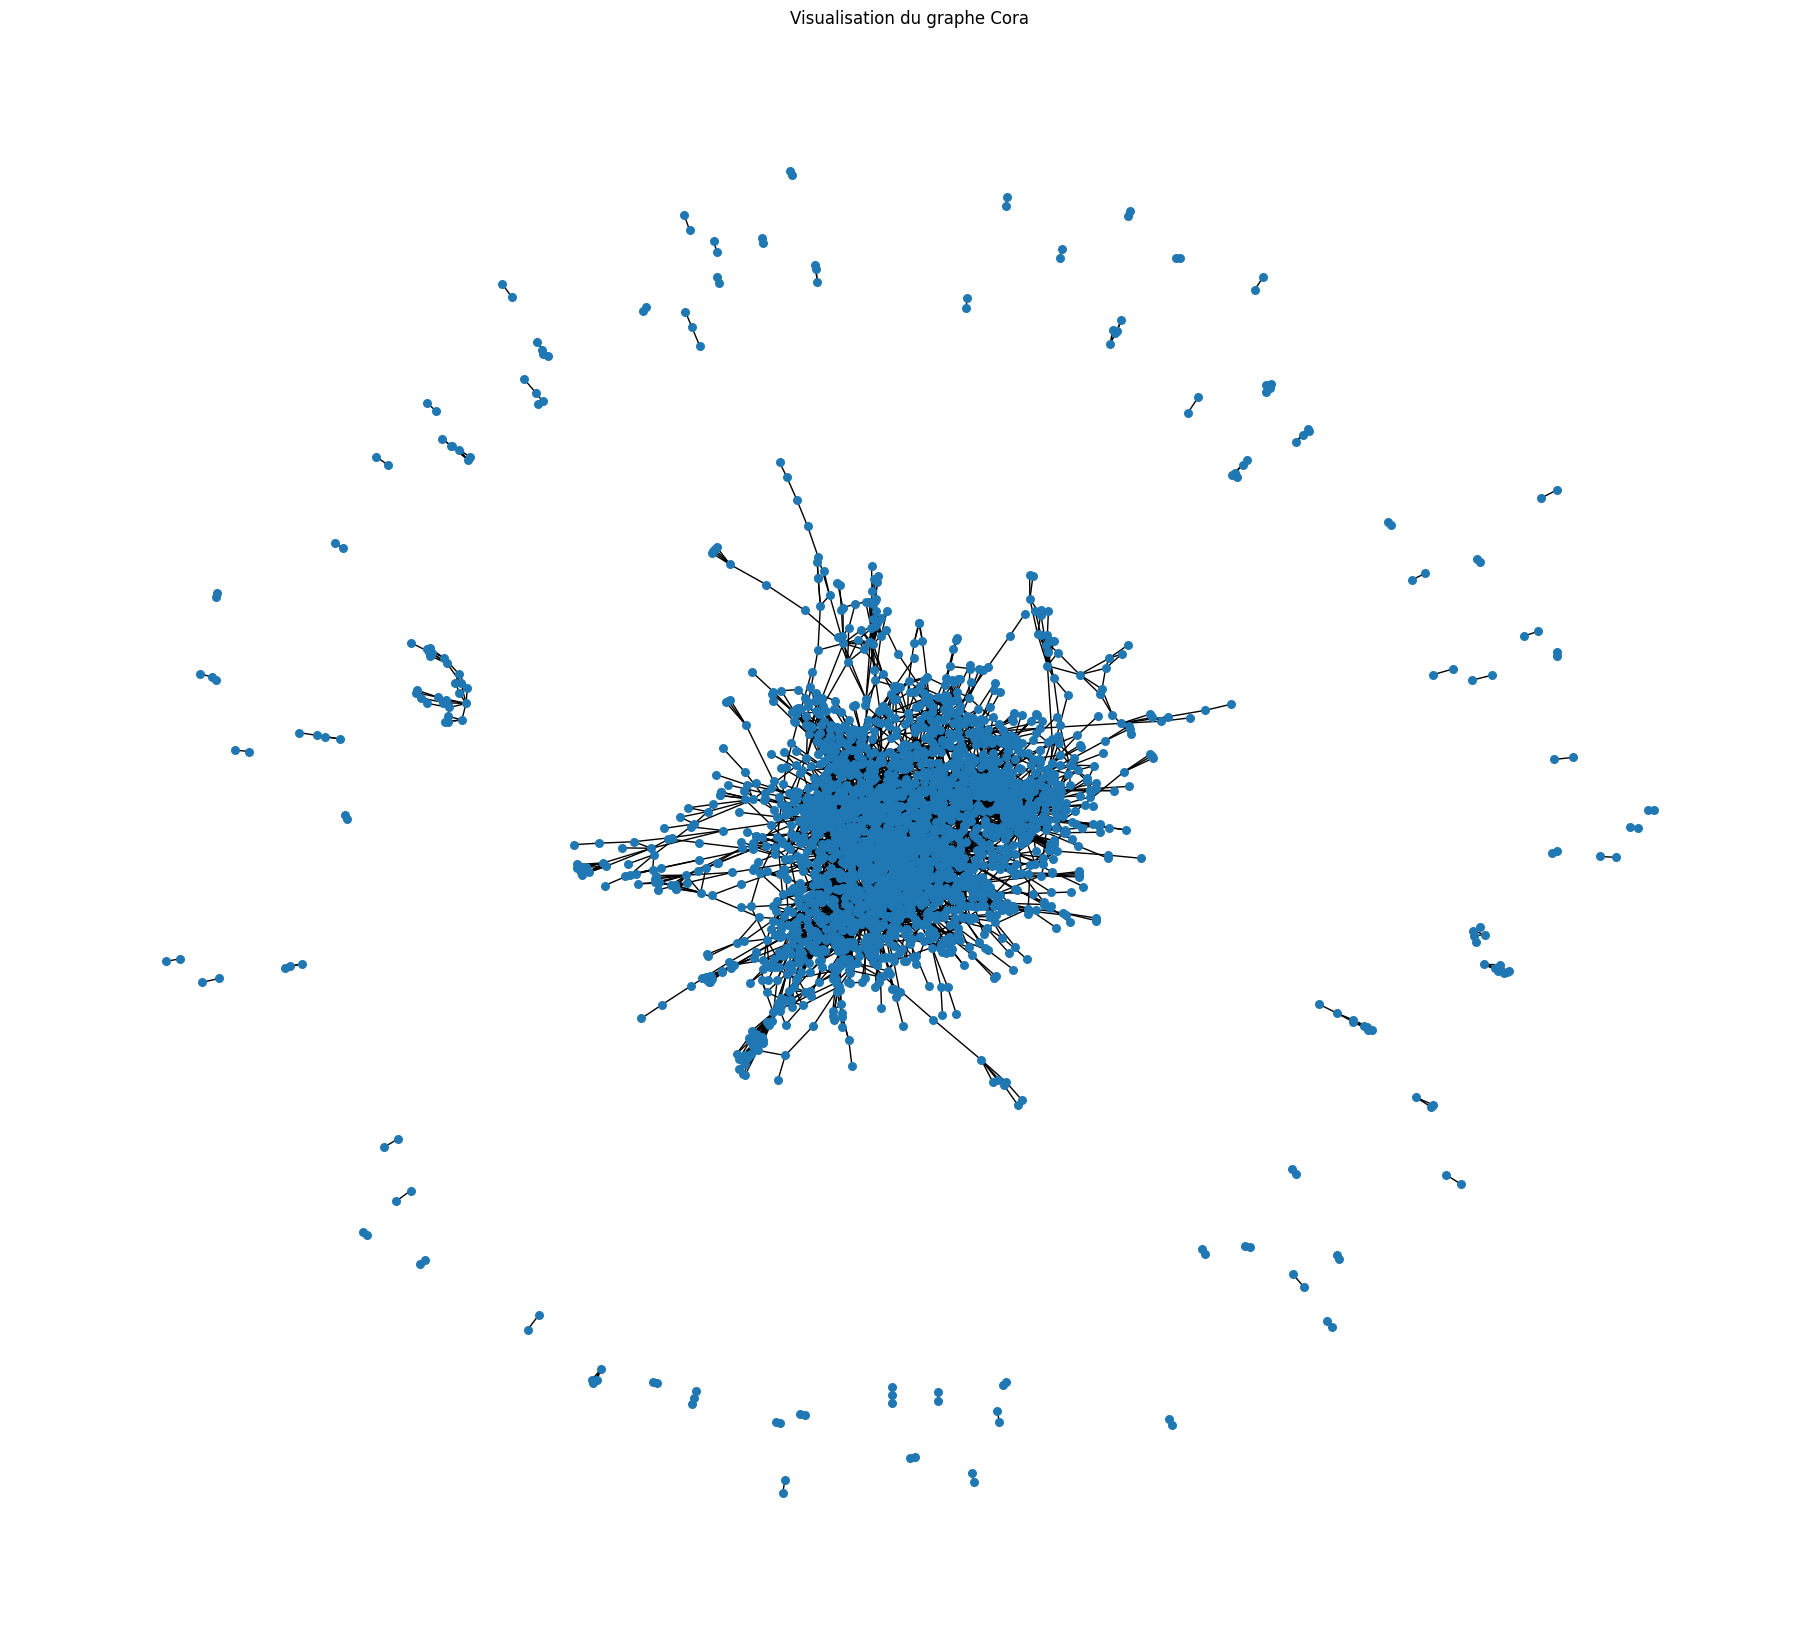

In [15]:
# Visualisation du graphe avec NetworkX
plt.figure(figsize=(18, 16))
nx.draw(G, with_labels=False, node_size=30)
plt.title('Visualisation du graphe Cora')
plt.show()

## Question 1 : construire un modèle à base de GAT qui permet de prédire la classe à laquelle appartient un noeud.
---

